### Developing a real stratergy to invest in the stock market

When developing our stratergy, the goal will be to acquire good and useful information about each stock. We then need to check which parameters play a role in explaining variation in the data and which simply contribute noise to the system. Once we have generated and calculated the financial indicators and then optimised the tuning of these params using something like simulated annealing to search the complex solution space we can test and compare our stratergy against the S&P500 real life data. 

Sentiment data could be useful, financial statements even better, unsure how to extract, useful information from these datasets.

Looking for monthly readjustments for our stock portfolio. Further investigation should be carried 
on arbitrage. 

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import os

In [46]:
# tickers = ["AAPL", "MSFT", "GOOGL", "EPAM", "KEY"]

# URL for S&P 500 companies on Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Read the first table from the Wikipedia page
sp500_table = pd.read_html(url)[0]

# Extract the ticker symbols
tickers = sp500_table['Symbol'].tolist()
# print(tickers)


start_date = "2018-01-01"
end_date = "2024-12-31"

In [47]:
def download_stock_data(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    return stock_data

data = download_stock_data(tickers, start_date, end_date)

# data_folder = "C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics"

# data = pd.read_csv("C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics/AAPL_stock_data.csv")

data.tail()

# data.to_csv('AAPL_stock_data.csv', index=True)

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
['BF.B', 'ETR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2018-01-01 -> 2024-12-31)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Ticker            IDXX                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2024-12-23  409.929993  413.369995  408.399994  413.160004  413.160004   
2024-12-24  412.350006  414.250000  409.839996  413.619995  413.619995   
2024-12-26  411.000000  417.959991  409.760010  417.109985  417.109985   
2024-12-27  413.730011  417.440002  410.429993  414.929993  414.929993   
2024-12-30  410.940002  414.700012  406.170013  412.750000  412.750000   

Ticker                      BLK                                         ...  \
Price       Volume         Open         High          Low        Close  ...   
Date                                                                    ...   
2024-12-23  413300  1025.890015  1041.359985  1023.359985  1039.699951  ...   
2024-12-24  159900  1041.640015  1054.829956  1036.670044  1054.829956  ...   
2024-12-26  333000  1045.000000  1057.489990  1045.000000  1054.280029  ...   
2024-12-27  375000  1048.000000  1055.439941  1040.260010  1044.180054  ...   
2024-12-30  388200  1032.810059  1036.050049  1021.479980  1027.430054  ...   

Ticker       VTRS                                  ALLE              \
Price         Low  Close Adj Close   Volume        Open        High   
Date                                                                  
2024-12-23  12.17  12.49     12.49  8585200  131.479996  132.550003   
2024-12-24  12.12  12.40     12.40  4059600  131.740005  133.130005   
2024-12-26  12.35  12.56     12.56  6194700  132.570007  134.000000   
2024-12-27  12.39  12.48     12.48  5182600  132.000000  133.330002   
2024-12-30  12.28  12.38     12.38  5822900  131.339996  131.570007   

Ticker                                                  
Price              Low       Close   Adj Close  Volume  
Date                                                    
2024-12-23  130.889999  132.130005  132.130005  588900  
2024-12-24  131.399994  133.039993  133.039993  248800  
2024-12-26  132.029999  132.990005  132.990005  386700  
2024-12-27  131.429993  131.970001  131.970001  429000  
2024-12-30  129.610001  130.970001  130.970001  298200  

[5 rows x 3018 columns]

In [48]:
multi_index_data = (
    data.stack(level=0, future_stack=True) # Pivot longer -> Takes ticker and makes it into a part of the index
    .swaplevel() # Swaps the order of the two index columns
    .sort_index() # Sorts the index
)

multi_index_data

Price                    Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
A      2018-01-02   67.419998   67.889999   67.339996   67.599998   64.180229   
       2018-01-03   67.620003   69.489998   67.599998   69.320000   65.813232   
       2018-01-04   69.540001   69.820000   68.779999   68.800003   65.319527   
       2018-01-05   68.730003   70.099998   68.730003   69.900002   66.363884   
       2018-01-08   69.730003   70.330002   69.550003   70.050003   66.506294   
...                       ...         ...         ...         ...         ...   
ZTS    2024-12-23  164.839996  165.830002  162.729996  164.279999  163.784851   
       2024-12-24  163.699997  165.039993  162.740005  164.699997  164.203583   
       2024-12-26  163.720001  165.789993  163.020004  165.520004  165.021118   
       2024-12-27  164.949997  166.529999  163.520004  164.600006  164.103897   
       2024-12-30  163.889999  164.050003  161.449997  162.240005  161.751007   

Price                 Volume  
Ticker Date                   
A      2018-01-02  1047800.0  
       2018-01-03  1698900.0  
       2018-01-04  2230700.0  
       2018-01-05  1632500.0  
       2018-01-08  1613400.0  
...                      ...  
ZTS    2024-12-23  2437800.0  
       2024-12-24  1023600.0  
       2024-12-26  2167200.0  
       2024-12-27  1800100.0  
       2024-12-30  1531400.0  

[885280 rows x 6 columns]

In [49]:
### Define and calcuate RSI 
def calculate_rsi(data, column='Adj Close', window=14):
    """
    Calculate the RSI for each stock in a multi-index df
    """
    def rsi_per_stock(data):
    
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Input data must be a pandas DataFrame")
    
        if column not in data.columns:
            raise ValueError(f"Column '{column}' not found in the DataFrame")
    
        # Calculate daily price changes (delta)
        delta = data['Adj Close'].diff()
    
        # Separate gains and losses
        gains = delta.clip(lower=0)
        losses = -delta.clip(upper=0)
        
        avg_gain = gains.rolling(window=window, min_periods=window).mean()
        avg_loss = losses.rolling(window=window, min_periods=window).mean()
    
        rs = avg_gain/avg_loss
        data['RSI'] = 100 - (100/ (1+rs)) # Ratio of avg gains/ avg losses during the window -> normalised to be 0 < rsi < 1
        
        return data
        
    return data.groupby(level='Ticker', group_keys=False).apply(rsi_per_stock)

def calculate_rsi_ewma(data, column="Adj Close", window=14):

    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    if column not in data.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame")

    def rsi_ewma_per_stock(data):
        # Calculate daily price changes (delta)
        delta = data[column].diff()
    
        # Separate gains and losses
        gains = delta.clip(lower=0)
        losses = -delta.clip(upper=0)
        
        avg_gain = gains.ewm(span=window, adjust=False).mean()
        avg_loss = losses.ewm(span=window, adjust=False).mean()
    
        rs = avg_gain/avg_loss
        rsi = 100 - (100/ (1+rs))

        data['RSI_EWMA'] = 100 - (100/ (1+rs)) # Ratio of exponentially smoothed gains/ losses during the window -> normalised to be 0 < rsi < 1
        return data
        
    return data.groupby(level='Ticker', group_keys=False).apply(rsi_ewma_per_stock)


def calculate_bollinger_bands(data, window=20):
    """
    Calculates Bollinger bands for multi-index df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")
    
    def calculate_bb_per_stock(data):
        bb_data = data['Adj Close']

        rolling_mean = bb_data.rolling(window=window).mean()
        rolling_std = bb_data.rolling(window=window).std()

        data[('Bollinger', 'Middle Band')] = rolling_mean
        data[('Bollinger', 'Upper Band')] = rolling_mean + (2 * rolling_std)
        data[('Bollinger', 'Lower Band')] = rolling_mean - (2 * rolling_std)

        return data

    return data.groupby(level='Ticker', group_keys=False).apply(calculate_bb_per_stock)
    

In [50]:
column = "Adj Close"

df = calculate_rsi(multi_index_data, column)

df = calculate_rsi_ewma(df, column=column, window=14)

df = calculate_bollinger_bands(df)

df.head(25)

Price                   Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
A      2018-01-02  67.419998  67.889999  67.339996  67.599998  64.180229   
       2018-01-03  67.620003  69.489998  67.599998  69.320000  65.813232   
       2018-01-04  69.540001  69.820000  68.779999  68.800003  65.319527   
       2018-01-05  68.730003  70.099998  68.730003  69.900002  66.363884   
       2018-01-08  69.730003  70.330002  69.550003  70.050003  66.506294   
       2018-01-09  70.680000  72.330002  70.169998  71.769997  68.139267   
       2018-01-10  71.449997  71.449997  70.110001  70.790001  67.208870   
       2018-01-11  70.919998  71.180000  70.300003  70.800003  67.218369   
       2018-01-12  70.730003  71.860001  70.500000  71.730003  68.101311   
       2018-01-16  72.019997  72.470001  71.059998  71.230003  67.626602   
       2018-01-17  71.720001  72.309998  71.589996  72.059998  68.414612   
       2018-01-18  72.199997  72.500000  71.669998  72.190002  68.538040   
       2018-01-19  72.480003  73.220001  72.059998  73.070000  69.373528   
       2018-01-22  73.169998  73.550003  72.599998  73.480003  69.762787   
       2018-01-23  74.050003  74.080002  73.250000  73.440002  69.724792   
       2018-01-24  73.660004  73.860001  73.050003  73.580002  69.857704   
       2018-01-25  74.169998  74.489998  73.650002  73.860001  70.123566   
       2018-01-26  74.300003  74.830002  73.589996  74.820000  71.034988   
       2018-01-29  74.480003  75.000000  74.300003  74.529999  70.759644   
       2018-01-30  73.989998  74.080002  72.930000  72.989998  69.297577   
       2018-01-31  73.769997  74.389999  73.239998  73.430000  69.715294   
       2018-02-01  73.180000  73.779999  72.510002  72.830002  69.145699   
       2018-02-02  72.320000  72.760002  71.220001  71.250000  67.645607   
       2018-02-05  70.860001  71.480003  68.180000  68.220001  64.768867   
       2018-02-06  66.959999  68.830002  66.129997  68.449997  64.987244   

Price                 Volume        RSI    RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                                     
A      2018-01-02  1047800.0        NaN         NaN                       NaN   
       2018-01-03  1698900.0        NaN  100.000000                       NaN   
       2018-01-04  2230700.0        NaN   95.555495                       NaN   
       2018-01-05  1632500.0        NaN   95.990453                       NaN   
       2018-01-08  1613400.0        NaN   96.051256                       NaN   
       2018-01-09  2666100.0        NaN   96.711129                       NaN   
       2018-01-10  2957200.0        NaN   87.138152                       NaN   
       2018-01-11  1511100.0        NaN   87.153132                       NaN   
       2018-01-12  1448100.0        NaN   88.579727                       NaN   
       2018-01-16  1702700.0        NaN   82.870884                       NaN   
       2018-01-17  1824500.0        NaN   84.753016                       NaN   
       2018-01-18  1828300.0        NaN   85.049902                       NaN   
       2018-01-19  2266100.0        NaN   87.023415                       NaN   
       2018-01-22  1963700.0        NaN   87.883275                       NaN   
       2018-01-23  1213400.0  79.435445   87.232287                       NaN   
       2018-01-24  1754300.0  75.539462   87.602948                       NaN   
       2018-01-25  1664100.0  81.234654   88.381444                       NaN   
       2018-01-26  2386900.0  80.904567   90.693236                       NaN   
       2018-01-29  1321900.0  77.654208   84.810855                       NaN   
       2018-01-30  1817000.0  57.702212   60.692353                 68.168241   
       2018-01-31  2032800.0  67.886029   64.061512                 68.444994   
       2018-02-01  2008200.0  62.735521   56.448923                 68.611618   
   

In [51]:
def calculate_macd(data, column="Adj Close", fast_period=12, slow_period=26, signal_period=9):
    """
    Calculate MACD, Signal Line, and MACD Histogram for multi-index df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_macd_per_stock(data):
        macd_data = data['Adj Close']
        
        fast_ema = macd_data.ewm(span=fast_period, adjust=False).mean()
        slow_ema = macd_data.ewm(span=slow_period, adjust=False).mean()
        
        data['MACD Line'] = macd_line = fast_ema - slow_ema
        data['Signal Line'] = signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

        # Calculate MACD histogram 
        data['Histogram'] = macd_line - signal_line

        return data

    return data.groupby(level='Ticker', group_keys=False).apply(calculate_macd_per_stock)


def calculate_atr(data, window=14):
    """
    Calculate the average true range for multi_index_df
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_atr_per_stock(data):
        # Extract relevant columns
        high = data['High']
        low = data['Low']
        close = data['Adj Close']

        # Calculate True Range (TR)
        true_range = pd.DataFrame({
            'high_low': high - low,
            'high_prev_close': (high - close.shift()).abs(),
            'low_prev_close': (low - close.shift()).abs()
        }).max(axis=1)

        # Calculate ATR using EMA
        data['ATR'] = true_range.ewm(span=window, adjust=False).mean()

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_atr_per_stock)

def calculate_roc(data, column="Adj Close", periods=14):
    """
    Calculate Rate of Change (RoC) for multi-index DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_roc_per_stock(data):
        # Extract relevant column
        roc_data = data[column]
        
        # Calculate RoC
        data['RoC'] = ((roc_data - roc_data.shift(periods)) / roc_data.shift(periods)) * 100

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_roc_per_stock)

# Might be something wrong with OBV looks oddly large numbers
def calculate_obv(data):
    """
    Calculate On-Balance Volume (OBV) for a multi-index DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_obv_per_stock(data):
        # Extract relevant columns
        close = data['Close']
        volume = data['Volume']

        # Calculate OBV
        obv = (volume * np.sign(close.diff())).fillna(0).cumsum()

        # Add OBV to the DataFrame
        data['OBV'] = obv

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_obv_per_stock)

def calculate_moving_averages(data, column="Adj Close", sma_window=50, ema_window=50):
    """
    Calculate SMA and EMA for a MultiIndex DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_averages_per_stock(data):
        # Extract relevant column
        price_data = data[column]
        
        # Calculate SMA
        data[f"SMA_{sma_window}"] = price_data.rolling(window=sma_window).mean()
        
        # Calculate EMA
        data[f"EMA_{ema_window}"] = price_data.ewm(span=ema_window, adjust=False).mean()

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_averages_per_stock)

def calculate_garman_klass_volatility(data):
    """
    Calculate Garman-Klass Volatility for a MultiIndex DataFrame.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_gk_per_stock(data):
        # Extract relevant columns
        high = data['High']
        low = data['Low']
        close = data['Close']
        open_price = data['Open']

        # Calculate Garman-Klass Volatility
        gk_volatility = (
            0.5 * (np.log(high / low) ** 2)
            - (2 * np.log(2) - 1) * (np.log(close / open_price) ** 2)
        )

        # Add Garman-Klass Volatility to the DataFrame
        data['GK Volatility'] = np.sqrt(gk_volatility)

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_gk_per_stock)

In [52]:
df = calculate_macd(df)

df = calculate_atr(df)

df = calculate_roc(df)

df = calculate_obv(df)

df = calculate_moving_averages(df)

df = calculate_garman_klass_volatility(df)

df.tail()

Price                    Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
ZTS    2024-12-23  164.839996  165.830002  162.729996  164.279999  163.784851   
       2024-12-24  163.699997  165.039993  162.740005  164.699997  164.203583   
       2024-12-26  163.720001  165.789993  163.020004  165.520004  165.021118   
       2024-12-27  164.949997  166.529999  163.520004  164.600006  164.103897   
       2024-12-30  163.889999  164.050003  161.449997  162.240005  161.751007   

Price                 Volume        RSI   RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                                    
ZTS    2024-12-23  2437800.0  25.949812  22.979873                173.575258   
       2024-12-24  1023600.0  28.861416  25.431247                172.876868   
       2024-12-26  2167200.0  31.784154  30.420177                172.369403   
       2024-12-27  1800100.0  25.913882  27.995499                171.764233   
       2024-12-30  1531400.0  18.544864  22.651515                171.115694   

Price              (Bollinger, Upper Band)  (Bollinger, Lower Band)  \
Ticker Date                                                           
ZTS    2024-12-23               183.649925               163.500591   
       2024-12-24               183.529952               162.223784   
       2024-12-26               183.517884               161.220923   
       2024-12-27               183.341301               160.187165   
       2024-12-30               183.425218               158.806169   

Price              MACD Line  Signal Line  Histogram       ATR       RoC  \
Ticker Date                                                                
ZTS    2024-12-23  -3.270347    -2.020781  -1.249567  3.916921 -7.154975   
       2024-12-24  -3.491832    -2.314991  -1.176841  3.701330 -6.057507   
       2024-12-26  -3.560350    -2.564063  -0.996287  3.577151 -5.292671   
       2024-12-27  -3.646627    -2.780576  -0.866052  3.501530 -6.721067   
       2024-12-30  -3.860361    -2.996533  -0.863828  3.388513 -8.930675   

Price                      OBV      SMA_50      EMA_50  GK Volatility  
Ticker Date                                                            
ZTS    2024-12-23  105369600.0  177.604711  176.446866       0.013175  
       2024-12-24  106393200.0  177.056477  175.966738       0.009173  
       2024-12-26  108560400.0  176.529766  175.537498       0.009786  
       2024-12-27  106760300.0  175.943930  175.089121       0.012830  
       2024-12-30  105228900.0  175.379467  174.566058       0.009384

In [53]:
def calculate_rolling_beta(data, market_column='MArket Pct Change', stock_column="Adj Close", window=30):
    """
    Calculate Rolling Beta for a MultiIndex DataFrame.

    The rolling Beta feature measures a stock's sensitivity to the market's movements over a rolling window
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input data must be a pandas DataFrame")

    def calculate_beta_per_stock(data):
        # Calculate daily stock and market returns
        stock_returns = data[stock_column].pct_change(fill_method=None)
        market_returns = data[market_column]

        # Rolling covariance and variance
        rolling_cov = stock_returns.rolling(window=window).cov(market_returns)
        rolling_var = market_returns.rolling(window=window).var()

        # Calculate Rolling Beta
        data['Rolling Beta'] = rolling_cov / rolling_var

        return data

    # Apply calculation per stock
    return data.groupby(level='Ticker', group_keys=False).apply(calculate_beta_per_stock)

In [54]:
# Define the market index (e.g., S&P 500)
market_ticker = "^GSPC"

# Fetch historical data
market_data = yf.download(market_ticker, start="2015-01-01", end="2024-12-31", progress=False)

market_data['Market Pct Change'] = market_data['Adj Close'].pct_change(fill_method=None)

# Get unique tickers from stock data
unique_tickers = df.index.get_level_values('Ticker').unique()

# Expand the market data for each ticker

# Creates the multi-index for the df
market_data_expanded = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [unique_tickers, market_data.index], 
        names=['Ticker', 'Date']
    )
)

# Replicates the data for however many unique tickers there are
market_data_expanded['Market Pct Change'] = np.tile(
    market_data['Market Pct Change'].values, len(unique_tickers)
)

# Combines this data now with our stock data
df = df.merge(
    market_data_expanded,
    left_index=True,
    right_index=True,
    how='left'
)

# print(df.groupby(level='Ticker')['Market Pct Change'].head())
# df = df.drop(columns='Market Returns')

In [55]:
df = calculate_rolling_beta(df, market_column='Market Pct Change', stock_column='Adj Close')

In [56]:
df.tail()

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
ZTS    2024-12-23  164.839996  165.830002  162.729996  164.279999  163.784851   
       2024-12-24  163.699997  165.039993  162.740005  164.699997  164.203583   
       2024-12-26  163.720001  165.789993  163.020004  165.520004  165.021118   
       2024-12-27  164.949997  166.529999  163.520004  164.600006  164.103897   
       2024-12-30  163.889999  164.050003  161.449997  162.240005  161.751007   

                      Volume        RSI   RSI_EWMA  (Bollinger, Middle Band)  \
Ticker Date                                                                    
ZTS    2024-12-23  2437800.0  25.949812  22.979873                173.575258   
       2024-12-24  1023600.0  28.861416  25.431247                172.876868   
       2024-12-26  2167200.0  31.784154  30.420177                172.369403   
       2024-12-27  1800100.0  25.913882  27.995499                171.764233   
       2024-12-30  1531400.0  18.544864  22.651515                171.115694   

                   (Bollinger, Upper Band)  ...  Signal Line  Histogram  \
Ticker Date                                 ...                           
ZTS    2024-12-23               183.649925  ...    -2.020781  -1.249567   
       2024-12-24               183.529952  ...    -2.314991  -1.176841   
       2024-12-26               183.517884  ...    -2.564063  -0.996287   
       2024-12-27               183.341301  ...    -2.780576  -0.866052   
       2024-12-30               183.425218  ...    -2.996533  -0.863828   

                        ATR       RoC          OBV      SMA_50      EMA_50  \
Ticker Date                                                                  
ZTS    2024-12-23  3.916921 -7.154975  105369600.0  177.604711  176.446866   
       2024-12-24  3.701330 -6.057507  106393200.0  177.056477  175.966738   
       2024-12-26  3.577151 -5.292671  108560400.0  176.529766  175.537498   
       2024-12-27  3.501530 -6.721067  106760300.0  175.943930  175.089121   
       2024-12-30  3.388513 -8.930675  105228900.0  175.379467  174.566058   

                   GK Volatility  Market Pct Change  Rolling Beta  
Ticker Date                                                        
ZTS    2024-12-23       0.013175           0.007287      0.430793  
       2024-12-24       0.009173           0.011043      0.432461  
       2024-12-26       0.009786          -0.000406      0.413037  
       2024-12-27       0.012830          -0.011056      0.405814  
       2024-12-30       0.009384          -0.010702      0.420507  

[5 rows x 22 columns]

In [57]:
"""

import requests
from bs4 import BeautifulSoup

# url = "https://www.quiverquant.com/congresstrading/"

# response = requests.get(url)
# if response.status_code == 200:
#     print("Successfully fetched webpage content!")
#     html_content = response.content
# else:
#     print(f"Failed to fetch webpage. Status code: {response.status_code}")

#Parse the HTML content
soup = BeautifulSoup(html_content, 'html.parser')

table = soup.find('table')

if table:
    print("Table found!")
else:
    print("No table found")

"""

'\n\nimport requests\nfrom bs4 import BeautifulSoup\n\n# url = "https://www.quiverquant.com/congresstrading/"\n\n# response = requests.get(url)\n# if response.status_code == 200:\n#     print("Successfully fetched webpage content!")\n#     html_content = response.content\n# else:\n#     print(f"Failed to fetch webpage. Status code: {response.status_code}")\n\n#Parse the HTML content\nsoup = BeautifulSoup(html_content, \'html.parser\')\n\ntable = soup.find(\'table\')\n\nif table:\n    print("Table found!")\nelse:\n    print("No table found")\n\n'

In [58]:
"""
# Extract all rows from the table
rows = table.find_all('tr')

# Loop through rows and extract cell data
data = []
for row in rows[1:]:
    cells = row.find_all('td')
    row_data = [cell.text.strip() for cell in cells] # Get text from each cell without whitespace
    data.append(row_data)

# print("Extracted data:", data[:5])

cleaned_data = []
for row in data:
    # Clean each cell in the row by stripping newlines and excessive spaces
    cleaned_row = [cell.replace("\n", "").replace("  ", " ").strip() for cell in row]
    cleaned_row = [" ".join(cell.split()) for cell in row]
    cleaned_data.append(cleaned_row)

print("Cleaned Data:", cleaned_data[:5])

"""

'\n# Extract all rows from the table\nrows = table.find_all(\'tr\')\n\n# Loop through rows and extract cell data\ndata = []\nfor row in rows[1:]:\n    cells = row.find_all(\'td\')\n    row_data = [cell.text.strip() for cell in cells] # Get text from each cell without whitespace\n    data.append(row_data)\n\n# print("Extracted data:", data[:5])\n\ncleaned_data = []\nfor row in data:\n    # Clean each cell in the row by stripping newlines and excessive spaces\n    cleaned_row = [cell.replace("\n", "").replace("  ", " ").strip() for cell in row]\n    cleaned_row = [" ".join(cell.split()) for cell in row]\n    cleaned_data.append(cleaned_row)\n\nprint("Cleaned Data:", cleaned_data[:5])\n\n'

In [59]:
"""
# Extract column names from the header row
header_row = rows[0]

headers = [th.text.strip() for th in header_row.find_all('th')]

print("Headers:", headers)
"""

'\n# Extract column names from the header row\nheader_row = rows[0]\n\nheaders = [th.text.strip() for th in header_row.find_all(\'th\')]\n\nprint("Headers:", headers)\n'

In [60]:
"""
import pandas as pd

# Refine our data cleaning to obtain singular elements
refined_data = []
for row in cleaned_data:
    # Split the Stock Column into Ticker and Company Name
    stock_parts = row[0].split(maxsplit=1)
    ticker = stock_parts[0].strip()
    company = stock_parts[1].strip() if len(stock_parts) > 1 else ""

    # Split the Transaction Column into Type and Amount Range
    transaction_parts = row[1].split("$", 1)
    transaction_type = transaction_parts[0].strip()
    # amount_range = "$" + transaction_parts[1].strip() if len(transaction_parts)>1 else ""
    if len(transaction_parts) > 1:
        # Further split the amount range to capture both numbers
        amount_range_parts = transaction_parts[1].split("-", 1)
        lower_amount = amount_range_parts[0].replace(",", "").strip()
        upper_amount = amount_range_parts[1].replace(",", "").strip() if len(amount_range_parts)>1 else ""
        upper_amount = upper_amount.replace("$", "").strip()
        amount_range = f"{lower_amount} - {upper_amount}"
    else:
        amount_range = ""
    
    # Split the Transaction Column into Type and Amount Range
    if "Senate" in row[2] or "House" in row[2]:
        split_point = row[2].find("Senate") if "Senate" in row[2] else row[2].find("House")
        politician_name = row[2][:split_point].strip()
        politician_affiliation = row[2][split_point:].strip()
    else:
        politician_name = row[2].strip()
        politican_affiliation = ""

    # Clean and parse the performance column
    performance = row[6].replace("%", "").strip()
    performance = float(performance) if performance not in ["-", ""] else None

    refined_data.append([
    ticker, company, transaction_type, amount_range, 
    politician_name, politician_affiliation, 
    row[3], row[4], performance
    ])

columns = [
    "Ticker", "Company", "Transaction Type", "Amount Range", 
    "Politician", "Affiliation", 
    "Reported Date", "Transaction Date", "Performance"
]

# Convert our data in a pandas df
politician_df = pd.DataFrame(refined_data, columns=columns)

# Convert dates to datetime format
politician_df["Reported Date"] = pd.to_datetime(df["Reported Date"], errors="coerce")
politician_df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")


politician_df.head()
"""

'\nimport pandas as pd\n\n# Refine our data cleaning to obtain singular elements\nrefined_data = []\nfor row in cleaned_data:\n    # Split the Stock Column into Ticker and Company Name\n    stock_parts = row[0].split(maxsplit=1)\n    ticker = stock_parts[0].strip()\n    company = stock_parts[1].strip() if len(stock_parts) > 1 else ""\n\n    # Split the Transaction Column into Type and Amount Range\n    transaction_parts = row[1].split("$", 1)\n    transaction_type = transaction_parts[0].strip()\n    # amount_range = "$" + transaction_parts[1].strip() if len(transaction_parts)>1 else ""\n    if len(transaction_parts) > 1:\n        # Further split the amount range to capture both numbers\n        amount_range_parts = transaction_parts[1].split("-", 1)\n        lower_amount = amount_range_parts[0].replace(",", "").strip()\n        upper_amount = amount_range_parts[1].replace(",", "").strip() if len(amount_range_parts)>1 else ""\n        upper_amount = upper_amount.replace("$", "").strip()

### Loading Historical Political trades

## Need to adjust for survivorship bias eventually

In [61]:
import os

data_folder = "C:/Users/codyr/Desktop/Coding_/Quant_Trading_Basics/Data"

political_data = pd.read_csv(os.path.join(data_folder, 'politician_trading_data_2020.csv'))

political_data['Transaction Date'] = pd.to_datetime(political_data['transaction_date'], errors='coerce')

political_data = political_data.set_index('Transaction Date')

political_data = political_data.sort_index()

political_data = political_data[(political_data.index >= '2019-01-01') & (political_data.index <= '2023-05-03')]

sp500_tickers = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')['Symbol'].tolist()

political_data = political_data[political_data['ticker'].isin(sp500_tickers)]

print(f"Filtered political data:\n\n{political_data.head()}")

Filtered political data:

                  disclosure_year disclosure_date transaction_date owner  \
Transaction Date                                                           
2019-01-09                   2020      04/27/2020       2019-01-09    --   
2019-01-09                   2020      04/27/2020       2019-01-09    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   
2019-01-23                   2020      04/27/2020       2019-01-23    --   

                 ticker             asset_description          type  \
Transaction Date                                                      
2019-01-09         DECK   Deckers Outdoor Corporation  sale_partial   
2019-01-09           RL      Ralph Lauren Corporation  sale_partial   
2019-01-23          AMD  Advanced Micro Devices, Inc.      purchase   
2019-01-23         DECK   Deckers Outdoor Corporation  sale_partial   
2019-01-23     

### Fetch historical data to determine what the adj closing price was on the transaction date

In [62]:
sp500_data = yf.download(sp500_tickers,start="2019-01-09",end="2023-05-03", group_by='ticker')

reshaped_data = sp500_data.stack(level=0, future_stack=True).swaplevel().sort_index()

filtered_stock_data = reshaped_data.loc[political_data['ticker'].unique()]

filtered_stock_data = filtered_stock_data['Adj Close']
filtered_stock_data.head()

filtered_stock_data = filtered_stock_data.reset_index()
filtered_stock_data.head()

political_data = political_data.reset_index()
political_data = political_data[["Transaction Date", "ticker", "type", "amount", "representative"]]
political_data = political_data.rename(columns={"Transaction Date": "Date", "ticker": "Ticker", "type": "Type", "amount": "Amount", "representative": "Representative"})
political_data.head()

# Merge the two datasets
merged_data = pd.merge(
    political_data,
    filtered_stock_data,
    on=['Ticker', 'Date'],
    how="inner"
)

merged_data = merged_data.set_index(["Ticker", "Date"])

merged_data.head()

[*********************100%***********************]  503 of 503 completed

8 Failed downloads:
['KVUE', 'SOLV', 'GEV', 'SW', 'VLTO']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-01-09 -> 2023-05-03) (Yahoo error = "Data doesn\'t exist for startDate = 1547010000, endDate = 1683086400")')
['BF.B', 'ETR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-01-09 -> 2023-05-03)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


,,Type,Amount,Representative,Adj Close
Ticker,Date,,,,
DECK,2019-01-09,sale_partial,"$1,001 - $15,000",Donna Shalala,21.103333
RL,2019-01-09,sale_partial,"$1,001 - $15,000",Donna Shalala,96.827087
AMD,2019-01-23,purchase,"$1,001 - $15,000",Donna Shalala,19.799999
DECK,2019-01-23,sale_partial,"$1,001 - $15,000",Donna Shalala,20.591667
PNR,2019-01-23,purchase,"$1,001 - $15,000",Donna Shalala,36.596729


In [63]:
# Define the mapping for amount ranges to midpoint values
amount_mapping = {
    '$1,001 - $15,000': 8000.0,
    '$15,001 - $50,000': 32500.0,
    '$50,001 - $100,000': 75000.0,
    '$100,001 - $250,000': 175000.0,
    '$1,001 -': 1001.0,  # Assume the minimum for open-ended range
    '$1,000,001 - $5,000,000': 3000000.0,
    '$250,001 - $500,000': 375000.0,
    '$500,001 - $1,000,000': 750000.0,
    '$5,000,001 - $25,000,000': 15000000.0,
    '$15,000 - $50,000': 32500.0,  # Align with similar range
    '$1,000 - $15,000': 8000.0     # Align with similar range
}

# Map the amount ranges to their midpoint values
merged_data['Amount'] = merged_data['Amount'].map(amount_mapping)

# Check the updated data
print(merged_data['Amount'].head(30))
print(merged_data['Amount'].isna().sum())

Ticker  Date      
DECK    2019-01-09     8000.0
RL      2019-01-09     8000.0
AMD     2019-01-23     8000.0
DECK    2019-01-23     8000.0
PNR     2019-01-23     8000.0
CAT     2019-01-29    32500.0
CL      2019-01-29     8000.0
KHC     2019-02-01     8000.0
CVX     2019-02-05     8000.0
VZ      2019-02-05     8000.0
AAPL    2019-02-05     8000.0
PFE     2019-02-05     8000.0
MSFT    2019-02-05     8000.0
BK      2019-02-05     8000.0
CB      2019-02-05     8000.0
COP     2019-02-05     8000.0
NEE     2019-02-05     8000.0
CSCO    2019-02-05     8000.0
LMT     2019-02-05     8000.0
WMT     2019-02-05     8000.0
MCD     2019-02-05     8000.0
LOW     2019-02-05     8000.0
JNJ     2019-02-05     8000.0
SRE     2019-02-05     8000.0
CMCSA   2019-02-05     8000.0
WFC     2019-02-05     8000.0
HPQ     2019-02-05     8000.0
CL      2019-02-05     8000.0
OXY     2019-02-05     8000.0
JPM     2019-02-05     8000.0
Name: Amount, dtype: float64
0


In [64]:
merged_data['Type'].unique()

array(['sale_partial', 'purchase', 'sale_full', 'exchange', 'sale'],
      dtype=object)

In [65]:
# Add a column for Quarter
merged_data['Quarter'] = merged_data.index.get_level_values('Date').to_period('Q')

def categorise_transaction_type(transaction_type):
    transaction_type = transaction_type.lower()
    if 'purchase' in transaction_type:
        return 'buy'
    elif'sale' in transaction_type:
        return 'sell'

merged_data['Transaction Category'] = merged_data['Type'].apply(categorise_transaction_type)

# Group by Ticker and Quarter
quarterly_aggregated = merged_data.groupby(['Ticker', 'Quarter']).agg(
    Total_Transactions=('Amount', 'count'),
    Total_Buy_Amount=(
        'Amount',
        lambda x: sum(
            amt for amt, trans_type in zip(x, merged_data.loc[x.index, 'Transaction Category']) if trans_type == 'buy'
        )
    ),
    Total_Sell_Amount=(
        'Amount',
        lambda x: sum(
            amt for amt, trans_type in zip(x, merged_data.loc[x.index, 'Transaction Category']) if trans_type == 'sell'
        )
    )
).reset_index()

# Calculate Net Buy-Sell Amount
quarterly_aggregated['Net_Buy_Sell'] = (
    quarterly_aggregated['Total_Buy_Amount'] - quarterly_aggregated['Total_Sell_Amount']
)

# Display the aggregated data
print(quarterly_aggregated.head())

  Ticker Quarter  Total_Transactions  Total_Buy_Amount  Total_Sell_Amount  \
0      A  2020Q2                   1               0.0             8000.0   
1      A  2021Q1                   1               0.0             8000.0   
2   AAPL  2019Q1                   1               0.0             8000.0   
3   AAPL  2019Q3                   3               0.0            48500.0   
4   AAPL  2019Q4                  12           48500.0           145500.0   

   Net_Buy_Sell  
0       -8000.0  
1       -8000.0  
2       -8000.0  
3      -48500.0  
4      -97000.0  


In [66]:
# Only include stocks in quarters which are traded more than 5 times. 
quarterly_aggregated = quarterly_aggregated[quarterly_aggregated['Total_Transactions']>=5]

In [67]:
import numpy as np

# Compute the Buy/Sell ratio
epsilon = 1e-6
quarterly_aggregated['Buy_Sell_Ratio'] = (quarterly_aggregated['Total_Buy_Amount'] + epsilon)/ (quarterly_aggregated['Total_Sell_Amount'] + epsilon)

# Logarithmic transformation to ease mean and std calculation
quarterly_aggregated['Log_Buy_Sell_Ratio'] = np.log(quarterly_aggregated['Buy_Sell_Ratio'])

# Calculate mean and standard deviation
mean_log_ratio = quarterly_aggregated['Log_Buy_Sell_Ratio'].mean()
std_log_ratio = quarterly_aggregated['Log_Buy_Sell_Ratio'].std()

print(f"Mean Log Ratio: {mean_log_ratio:.4f}")
print(f"Standard Deviation of Log Ratio: {std_log_ratio:.4f}")

# Calculate z-score
quarterly_aggregated['Z_Score'] = (quarterly_aggregated['Log_Buy_Sell_Ratio'] - mean_log_ratio) / std_log_ratio

# Function to assign signals
def assign_signal(z):
    if z >= 2:
        return 'Strong Buy'
    elif 1 <= z < 2:
        return 'Buy'
    elif 0 < z < 1:
        return 'Weak Buy - Hold'
    elif -1 < z < 0:
        return 'Weak Sell - Hold'
    elif -2 < z <= -1:
        return 'Sell'
    else:
        return 'Strong Sell'

# Apply the function to assign signals
quarterly_aggregated['Signal'] = quarterly_aggregated['Z_Score'].apply(assign_signal)

# Calculate confidence score
quarterly_aggregated['Confidence'] = quarterly_aggregated['Z_Score'].abs()

print(quarterly_aggregated[['Ticker', 'Quarter', 'Total_Buy_Amount', 'Total_Sell_Amount', 'Buy_Sell_Ratio', 'Log_Buy_Sell_Ratio', 'Z_Score', 'Signal', 'Confidence']].head())

Mean Log Ratio: 0.8755
Standard Deviation of Log Ratio: 11.1354
  Ticker Quarter  Total_Buy_Amount  Total_Sell_Amount  Buy_Sell_Ratio  \
4   AAPL  2019Q4           48500.0           145500.0        0.333333   
5   AAPL  2020Q1         1011000.0          7113501.0        0.142124   
6   AAPL  2020Q2         4679500.0          3129000.0        1.495526   
7   AAPL  2020Q3           41501.0           315500.0        0.131540   
8   AAPL  2020Q4          170000.0          1254500.0        0.135512   

   Log_Buy_Sell_Ratio   Z_Score            Signal  Confidence  
4           -1.098612 -0.177282  Weak Sell - Hold    0.177282  
5           -1.951055 -0.253835  Weak Sell - Hold    0.253835  
6            0.402478 -0.042479  Weak Sell - Hold    0.042479  
7           -2.028441 -0.260784  Weak Sell - Hold    0.260784  
8           -1.998694 -0.258113  Weak Sell - Hold    0.258113  


### Building out an initial portfolio from historical stock data alone

In [68]:
df.rename(columns={('Bollinger', 'Middle Band'): 'Middle Band', ('Bollinger', 'Lower Band'): 'Lower Band', ('Bollinger', 'Upper Band'): 'Upper Band'}, inplace=True)

# Dropping NA's
df = df.groupby('Ticker', group_keys=False).apply(lambda x: x.iloc[50:])
df.reset_index()

df.head()

Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
A      2018-03-15  70.089996  70.660004  69.870003  70.180000  66.629707   
       2018-03-16  69.919998  70.339996  69.050003  69.900002  66.363884   
       2018-03-19  69.790001  70.309998  69.059998  69.339996  65.832214   
       2018-03-20  69.769997  70.070000  69.449997  69.849998  66.316422   
       2018-03-21  69.879997  70.089996  69.360001  69.400002  65.889175   

                      Volume        RSI   RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                   
A      2018-03-15  2530400.0  46.955339  54.500720    66.391894   69.143608   
       2018-03-16  3378100.0  46.091861  50.802477    66.291257   68.879722   
       2018-03-19  2639400.0  52.213438  43.924007    66.166409   68.575671   
       2018-03-20  2379100.0  58.097875  50.908720    66.108020   68.438114   
       2018-03-21  1583200.0  64.387529  45.179356    66.020198   68.235876   

                   ...  Signal Line  Histogram       ATR       RoC  \
Ticker Date        ...                                               
A      2018-03-15  ...    -0.168522   0.177155  4.324478 -0.735542   
       2018-03-16  ...    -0.132773   0.142996  4.242586 -0.963467   
       2018-03-19  ...    -0.112431   0.081370  4.203057  0.492730   
       2018-03-20  ...    -0.094830   0.070404  4.207687  1.837038   
       2018-03-21  ...    -0.086470   0.033439  4.149805  2.997929   

                          OBV     SMA_50     EMA_50  GK Volatility  \
Ticker Date                                                          
A      2018-03-15  16411600.0  66.985560  66.266633       0.007910   
       2018-03-16  13033500.0  66.996573  66.270447       0.013087   
       2018-03-19  10394100.0  67.006827  66.253261       0.012030   
       2018-03-20  12773200.0  67.005878  66.255738       0.006244   
       2018-03-21  11190000.0  66.993536  66.241363       0.006038   

                   Market Pct Change  Rolling Beta  
Ticker Date                                         
A      2018-03-15          -0.000782      1.050296  
       2018-03-16           0.001703      1.048277  
       2018-03-19          -0.014204      1.034570  
       2018-03-20           0.001482      1.036482  
       2018-03-21          -0.001844      1.104072  

[5 rows x 22 columns]

Next steps:
- We need to focus on actually contriving some sort of model which can predict which stocks to include in portfolio.
- We need to offset the dates so that the current month decides the portfolio makeup for next month

## Constructing an initial portfolio

### Transformations

- Log Transformation for Volume – Prevents massive differences between small and large-cap stocks.
- Z-score for Technical Indicators – Ensures comparability by standardizing mean and variance.
- MinMax for OBV – Since OBV accumulates, MinMax scaling ensures it's relative across stocks.
- No Scaling for Market % Change & Beta – As they are already in a comparable format.

In [69]:
# Step 1: Compute Log Returns (Corrected)
df['Log Return'] = df.groupby(level='Ticker')['Adj Close'].pct_change(fill_method=None).apply(lambda x: np.log1p(x))

# Step 2: Compute Rolling Cumulative Returns (Momentum)
df['Quarterly Cumulative Return'] = df.groupby(level='Ticker')['Log Return']\
    .rolling(window=63, min_periods=30).sum().droplevel(0)  # Quarterly Momentum

# Step 3: Compute Rolling Volatility
df['Quarterly Volatility'] = df.groupby(level='Ticker')['Log Return']\
    .rolling(window=63, min_periods=30).std().droplevel(0)  # Quarterly Volatility

# Step 4: Compute Sharpe Ratio
df['Sharpe Ratio'] = df['Quarterly Cumulative Return'] / df['Quarterly Volatility']

In [70]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Define feature groups based on their characteristics
z_score_features = ['ATR', 'GK Volatility', 'RSI', 'RSI_EWMA', 'MACD Line', 
                    'Signal Line', 'Histogram', 'RoC', 'SMA_50', 'EMA_50', 
                    'Middle Band', 'Upper Band', 'Lower Band', 'Log Return']
minmax_features = ['OBV', 'Sharpe Ratio']  # robust MinMax ensures OBV stays within 0-1
log_features = ['Volume']  # Log transformation for highly skewed data
no_scaling_features = ['Market Pct Change', 'Rolling Beta'] #, 'Quarterly Cumulative Return', 'Quarterly Cumulative Return', 'Sharpe Ratio']

# Apply Standard Scaling (Z-score normalization)
scaler_std = StandardScaler()
df_standardized = pd.DataFrame(scaler_std.fit_transform(df[z_score_features]), 
                               columns=z_score_features, index=df.index)

# Apply robust MinMax Scaling (0 to 1)
scaler_robust = RobustScaler()
df_robust_minmax = pd.DataFrame(scaler_robust.fit_transform(df[minmax_features]), 
                         columns=minmax_features, index=df.index)

# Apply Log transformation (log(1 + x) to handle zero values)
df_log = df.copy()
df_log[log_features] = np.log1p(df[log_features])

# Keep unscaled features
df_transformed = df.copy()
df_transformed[z_score_features] = df_standardized
df_transformed[minmax_features] = df_robust_minmax
df_transformed[log_features] = df_log[log_features]
df_transformed[no_scaling_features] = df[no_scaling_features]

df_transformed.tail()

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
ZTS    2024-12-23  164.839996  165.830002  162.729996  164.279999  163.784851   
       2024-12-24  163.699997  165.039993  162.740005  164.699997  164.203583   
       2024-12-26  163.720001  165.789993  163.020004  165.520004  165.021118   
       2024-12-27  164.949997  166.529999  163.520004  164.600006  164.103897   
       2024-12-30  163.889999  164.050003  161.449997  162.240005  161.751007   

                      Volume       RSI  RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                 
ZTS    2024-12-23  14.706607 -1.584049 -1.808708     0.094453    0.093133   
       2024-12-24  13.838837 -1.412075 -1.659413     0.092068    0.092745   
       2024-12-26  14.588947 -1.239443 -1.355576     0.090335    0.092706   
       2024-12-27  14.403353 -1.586171 -1.503244     0.088268    0.092135   
       2024-12-30  14.241694 -2.021423 -1.828706     0.086054    0.092406   

                   ...       OBV    SMA_50    EMA_50  GK Volatility  \
Ticker Date        ...                                                
ZTS    2024-12-23  ...  0.516874  0.113594  0.109982      -0.197950   
       2024-12-24  ...  0.525398  0.111697  0.108318      -0.590181   
       2024-12-26  ...  0.543446  0.109874  0.106832      -0.530160   
       2024-12-27  ...  0.528455  0.107847  0.105278      -0.231766   
       2024-12-30  ...  0.515702  0.105893  0.103466      -0.569515   

                   Market Pct Change  Rolling Beta  Log Return  \
Ticker Date                                                      
ZTS    2024-12-23           0.007287      0.430793   -0.171666   
       2024-12-24           0.011043      0.432461    0.096965   
       2024-12-26          -0.000406      0.413037    0.205794   
       2024-12-27          -0.011056      0.405814   -0.269561   
       2024-12-30          -0.010702      0.420507   -0.669497   

                   Quarterly Cumulative Return  Quarterly Volatility  \
Ticker Date                                                            
ZTS    2024-12-23                    -0.162320              0.013558   
       2024-12-24                    -0.148552              0.013527   
       2024-12-26                    -0.160874              0.013326   
       2024-12-27                    -0.166140              0.013328   
       2024-12-30                    -0.183503              0.013391   

                   Sharpe Ratio  
Ticker Date                      
ZTS    2024-12-23     -1.367058  
       2024-12-24     -1.271296  
       2024-12-26     -1.376681  
       2024-12-27     -1.414675  
       2024-12-30     -1.534374  

[5 rows x 26 columns]

### Adding final features and interaction terms

In [71]:
# Ensure dataset is sorted
df_transformed = df_transformed.sort_index()

df_transformed['Lag_1_Log_Return'] = df_transformed.groupby(level='Ticker')['Log Return'].shift(1)
df_transformed['Lag_5_Log_Return'] = df_transformed.groupby(level='Ticker')['Log Return'].shift(5)
df_transformed['Lag_21_Log_Return'] = df_transformed.groupby(level='Ticker')['Log Return'].shift(21)

df_transformed['Rolling_Mean_5'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=5, min_periods=3).mean().droplevel(0)
df_transformed['Rolling_Mean_21'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=21, min_periods=10).mean().droplevel(0)
df_transformed['Rolling_Mean_63'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=63, min_periods=30).mean().droplevel(0)

df_transformed['Rolling_Std_5'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=5, min_periods=3).std().droplevel(0)
df_transformed['Rolling_Std_21'] = df_transformed.groupby(level='Ticker')['Log Return'].rolling(window=21, min_periods=10).std().droplevel(0)

# Interaction terms
df_transformed['Momentum_Beta_Interaction'] = df_transformed['Quarterly Cumulative Return'] * df_transformed['Rolling Beta']
df_transformed['Sharpe_Momentum_Interaction'] = df_transformed['Sharpe Ratio'] * df_transformed['Quarterly Cumulative Return']

# Drop any NaN values generated by shifts
df_transformed.dropna(inplace=True)

In [72]:
# Cut off dates
train_cutoff = '2020-12-31'
val_cutoff = '2022-12-31'

# Train set up
train_data = df_transformed[df_transformed.index.get_level_values('Date') <= train_cutoff]

# Validation set
val_data = df_transformed[(df_transformed.index.get_level_values('Date') > train_cutoff) & 
    (df_transformed.index.get_level_values('Date') <= val_cutoff)]

# test daTA
test_data = df_transformed[df_transformed.index.get_level_values('Date') > val_cutoff]

# Print sizes
print(f"Train set: {train_data.shape}")
print(f"Validation set: {val_data.shape}")
print(f"Test set: {test_data.shape}")

Train set: (328854, 36)
Validation set: (248136, 36)
Test set: (248944, 36)


In [73]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [74]:
X_train = train_data.drop(columns=['Log Return'])
y_train = train_data['Log Return']

X_valid = val_data.drop(columns=['Log Return'])
y_valid = val_data['Log Return']

X_test = test_data.drop(columns=['Log Return'])
y_test = test_data['Log Return']

# Convert to DMatrix (XGBoost optimized format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 3: Train XGBoost Model with Early Stopping
evals = [(dtrain, 'train'), (dvalid, 'valid')]

In [75]:
# Step 2: Define XGBoost Parameters
params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'random_state': 42
}

## Train XGboost model
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=True
)

[0]	train-rmse:1.13837	valid-rmse:0.95420
[1]	train-rmse:1.13408	valid-rmse:0.95122
[2]	train-rmse:1.12820	valid-rmse:0.94717
[3]	train-rmse:1.12237	valid-rmse:0.94322
[4]	train-rmse:1.11854	valid-rmse:0.94059
[5]	train-rmse:1.11287	valid-rmse:0.93674
[6]	train-rmse:1.10908	valid-rmse:0.93403
[7]	train-rmse:1.10365	valid-rmse:0.93033
[8]	train-rmse:1.09974	valid-rmse:0.92752
[9]	train-rmse:1.09576	valid-rmse:0.92476
[10]	train-rmse:1.09053	valid-rmse:0.92130
[11]	train-rmse:1.08515	valid-rmse:0.91762
[12]	train-rmse:1.07983	valid-rmse:0.91395
[13]	train-rmse:1.07469	valid-rmse:0.91037
[14]	train-rmse:1.06952	valid-rmse:0.90684
[15]	train-rmse:1.06447	valid-rmse:0.90338
[16]	train-rmse:1.05969	valid-rmse:0.90023
[17]	train-rmse:1.05485	valid-rmse:0.89693
[18]	train-rmse:1.04992	valid-rmse:0.89362
[19]	train-rmse:1.04527	valid-rmse:0.89056
[20]	train-rmse:1.04056	valid-rmse:0.88739
[21]	train-rmse:1.03601	valid-rmse:0.88448
[22]	train-rmse:1.03136	valid-rmse:0.88127
[23]	train-rmse:1.026

In [76]:
# Step 4: Evaluate Performance
y_pred = xgb_model.predict(dtest)

# Compute RMSE and R² Score
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.6f}")
print(f"Test R² Score: {r2:.6f}")

Test RMSE: 0.366905
Test R² Score: 0.463038


<Figure size 1000x600 with 0 Axes>

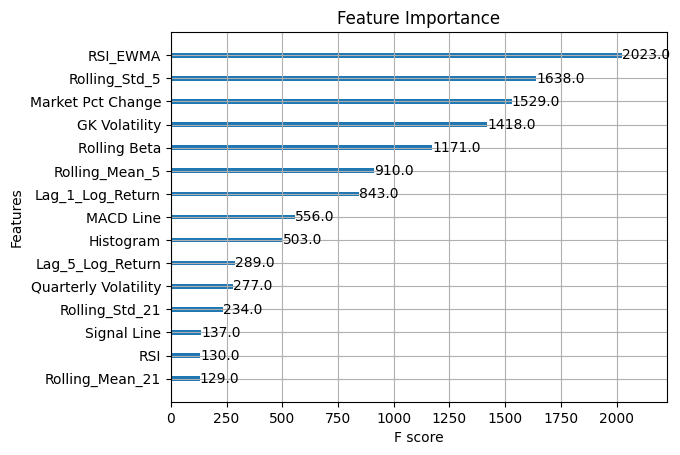

In [77]:
import matplotlib.pyplot as plt

# Feature importance plot
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=15)
plt.title("Feature Importance")
plt.show()

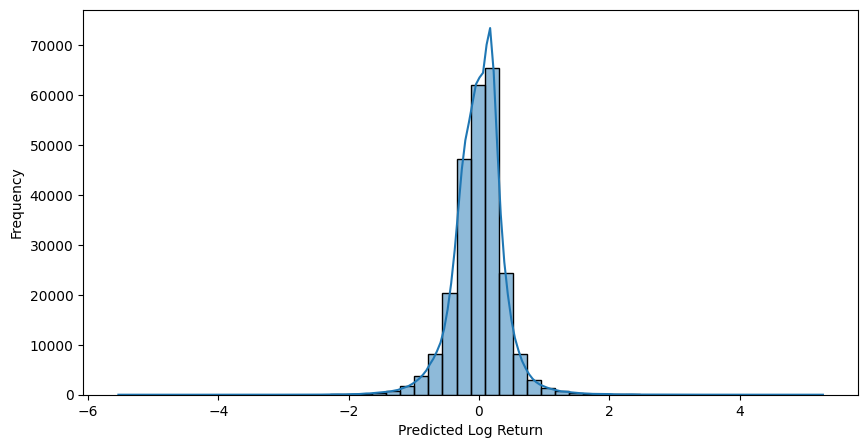

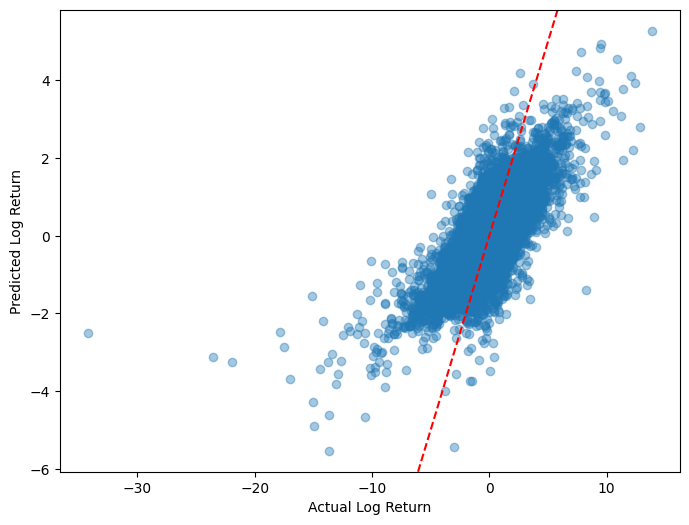

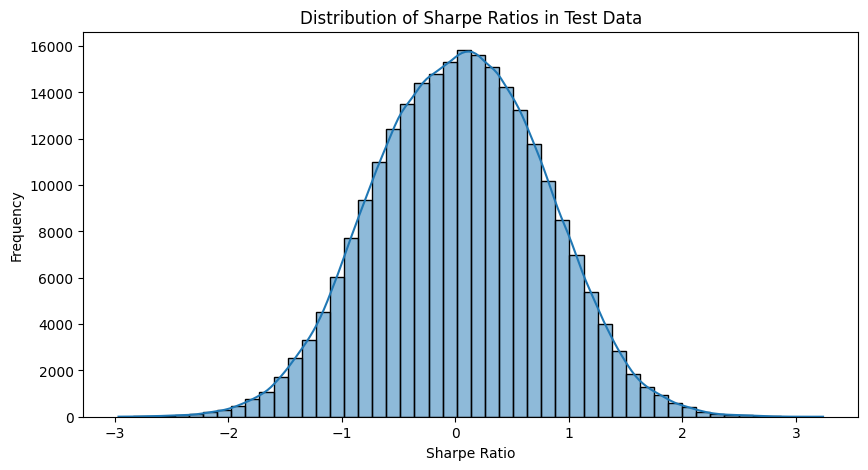

In [78]:
import seaborn as sns

## Histogram of predicted log returns
plt.figure(figsize=(10, 5))
sns.histplot(y_pred, bins=50, kde=True)
plt.xlabel('Predicted Log Return')
plt.ylabel("Frequency")
plt.show()

# Scatter plot: Predicted vs actual Log Returns
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.axline((0,0), slope=1, color='red', linestyle='--') # Reference line to see deviations easily
plt.xlabel("Actual Log Return")
plt.ylabel("Predicted Log Return")
plt.show()

# Histogram of Sharpe Ratios for selected stocks
plt.figure(figsize=(10, 5))
sns.histplot(X_test["Sharpe Ratio"], bins=50, kde=True)
plt.xlabel("Sharpe Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Sharpe Ratios in Test Data")
plt.show()

## Building out our initial portfolio

In [189]:
# Define aggregation rules
agg_rules = {
    'Open': 'first',  # First open price of the quarter
    'High': 'max',  # Highest price during the quarter
    'Low': 'min',  # Lowest price during the quarter
    'Close': 'last',  # Closing price at the end of the quarter
    'Adj Close': 'last',  # Adjusted closing price
    'Volume': 'sum',  # Total trading volume in the quarter
    'RSI': 'mean',
    'RSI_EWMA': 'mean',
    'Middle Band': 'mean',
    'Upper Band': 'mean',
    'Lower Band': 'mean',
    'MACD Line': 'mean',
    'Signal Line': 'mean',
    'Histogram': 'mean',
    'ATR': 'mean',
    'RoC': 'mean',
    'OBV': 'last',  # Use last value for On-Balance Volume
    'SMA_50': 'mean',
    'EMA_50': 'mean',
    'GK Volatility': 'mean',
    'Market Pct Change': 'sum',  # Accumulate market returns over the quarter
    'Rolling Beta': 'mean',
    'Quarterly Cumulative Return': 'last',  # Use last cumulative return value
    'Quarterly Volatility': 'mean',
    'Sharpe Ratio': 'mean',
    'Lag_1_Log_Return': 'sum',
    'Lag_5_Log_Return': 'sum',
    'Lag_21_Log_Return': 'sum',
    'Rolling_Mean_5': 'mean',
    'Rolling_Mean_21': 'mean',
    'Rolling_Mean_63': 'mean',
    'Rolling_Std_5': 'mean',
    'Rolling_Std_21': 'mean',
    'Momentum_Beta_Interaction': 'mean',
    'Sharpe_Momentum_Interaction': 'mean'
}

# Resample to quarterly periods
df_quarterly = df_transformed.groupby(['Ticker', pd.Grouper(level='Date', freq='QE')]).agg(agg_rules)

# Aggregate log returns correctly by first converting to normal returns, summing, and converting back
normal_returns = df_transformed.groupby(['Ticker', pd.Grouper(level='Date', freq='QE')])['Log Return'] \
    .apply(lambda x: np.expm1(x).sum())  # Convert log returns to normal returns and sum them

# Ensure values are valid for log1p (must be > -1 to avoid math errors)
normal_returns = normal_returns.clip(lower=-0.99)  # Prevent log1p from breaking

# Convert back to log returns
df_quarterly['Log Return'] = np.log1p(normal_returns)

print(df_quarterly.head())  # Check the aggregated dataframe
print(df_quarterly.describe())  # Ensure values look correct

                        Open       High        Low      Close  Adj Close  \
Ticker Date                                                                
A      2018-06-30  66.339996  70.449997  60.419998  61.840000  58.842678   
       2018-09-30  61.360001  71.459999  60.790001  70.540001  67.283112   
       2018-12-31  70.680000  75.110001  61.009998  67.459999  64.640984   
       2019-03-31  66.500000  82.269997  62.000000  80.379997  77.021103   
       2019-06-30  80.959999  82.239998  66.029999  74.669998  71.695969   

                       Volume       RSI  RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                  
A      2018-06-30  667.288674 -0.378232 -0.396883    -0.285439   -0.288306   
       2018-09-30  912.196435  0.446960  0.467175    -0.286053   -0.291874   
       2018-12-31  932.445194 -0.247308 -0.266898    -0.277431   -0.276549   
       2019-03-31  876.624326  0.732886  0.727309    -0.256640   -0.259383   

In [181]:
df_quarterly.tail()

Open        High         Low       Close   Adj Close  \
Ticker Date                                                                     
ZTS    2023-12-31  173.199997  201.919998  151.029999  197.369995  194.845352   
       2024-03-31  195.789993  200.529999  164.110001  169.210007  167.424438   
       2024-06-30  168.990005  181.660004  144.800003  173.360001  172.019730   
       2024-09-30  173.259995  200.330002  171.509995  195.380005  194.330627   
       2024-12-31  195.449997  196.550003  161.449997  162.240005  161.751007   

                       Volume       RSI  RSI_EWMA  Middle Band  Upper Band  \
Ticker Date                                                                  
ZTS    2023-12-31  904.140398  0.114460  0.093478     0.089496    0.093846   
       2024-03-31  898.733533 -0.660859 -0.573754     0.146333    0.142322   
       2024-06-30  936.808741 -0.100462 -0.109325     0.064703    0.067331   
       2024-09-30  921.879093  0.450311  0.429163     0.116439    0.102759   
       2024-12-31  919.191078 -0.667757 -0.704183     0.123503    0.110407   

                   ...  Lag_1_Log_Return  Lag_5_Log_Return  Lag_21_Log_Return  \
Ticker Date        ...                                                          
ZTS    2023-12-31  ...          4.594975          3.332707          -5.180218   
       2024-03-31  ...         -8.088926         -7.564285           4.798153   
       2024-06-30  ...          1.061524         -0.281373          -8.121777   
       2024-09-30  ...          3.404743          4.515195           2.027452   
       2024-12-31  ...         -8.638740         -8.289708          -2.581820   

                   Rolling_Mean_5  Rolling_Mean_21  Rolling_Mean_63  \
Ticker Date                                                           
ZTS    2023-12-31        0.064217         0.016285        -0.035927   
       2024-03-31       -0.131847        -0.071705         0.027402   
       2024-06-30        0.000984        -0.033319        -0.102074   
       2024-09-30        0.068139         0.055965         0.056625   
       2024-12-31       -0.135790        -0.094445        -0.038261   

                   Rolling_Std_5  Rolling_Std_21  Momentum_Beta_Interaction  \
Ticker Date                                                                   
ZTS    2023-12-31       0.590562        0.664271                  -0.032173   
       2024-03-31       0.677381        0.734838                   0.063147   
       2024-06-30       0.733609        0.776341                  -0.122222   
       2024-09-30       0.561951        0.634239                   0.024147   
       2024-12-31       0.559690        0.577118                  -0.011268   

                   Sharpe_Momentum_Interaction  
Ticker Date                                     
ZTS    2023-12-31                     0.057642  
       2024-03-31                     0.089787  
       2024-06-30                     0.130210  
       2024-09-30                     0.063325  
       2024-12-31                     0.054329  

[5 rows x 36 columns]

## An idea would be to merge the quaterly dataset with the daily dataset to provide both short and long term information for the model.

In [255]:
def rebalance_portfolio(df_quarterly, xgb_model, rebalance_dates):
    """
    Function to rebalance our portfolio quarterly based on the results of our XGBoost model.
    """
    portfolio_history = []
    portfolio_value = 1  # Start with an initial portfolio value of 1

    for quarter in rebalance_dates:
        # Select data for the current quarter
        quarter_data = df_quarterly[df_quarterly.index.get_level_values('Date') == quarter].copy()

        # Prepare the data for prediction
        X_quarter = quarter_data.drop(columns=['Log Return'], errors='ignore')

        # Convert DataFrame to DMatrix
        dquarter = xgb.DMatrix(X_quarter)

        # Predict using the trained model
        quarter_data['Predicted Log Return'] = xgb_model.predict(dquarter)
        # print(quarter_data[['Predicted Log Return', 'Sharpe Ratio']])

        
        # Select the top 20 stocks based on predicted returns
        quarter_data = quarter_data[quarter_data['Sharpe Ratio'] > 0]
        top_n = min(20, len(quarter_data))
        top_20_stocks = quarter_data.nlargest(top_n, 'Predicted Log Return').copy()

        # print(top_20_stocks[['Predicted Log Return', 'Sharpe Ratio']])
        
        # Compute risk-adjusted weights based on Sharpe Ratio
        sharpe_ratios = top_20_stocks['Sharpe Ratio']
        weights = np.exp(sharpe_ratios) / np.sum(np.exp(sharpe_ratios))

        # Cap weights at 15% per stock and re-normalize
        weights = weights.clip(upper=0.15)  # Cap at 15%
        weights /= weights.sum()  # Ensure the sum of weights equals 1

        print(top_20_stocks[['Predicted Log Return', 'Sharpe Ratio']])
        print(weights)
        
        # Store portfolio allocation
        top_20_stocks['Weights'] = weights.values
        # top_20_stocks['Quarter'] = quarter.strftime('%Y-%m-%d')  # Ensure it's a string

        # print(portfolio_results[['Log Return', 'Portfolio Value', 'Weights']].describe())
        # print(top_20_stocks[['Weights']].sum())  # Should be 1
        
        # Compute portfolio return for the quarter
        portfolio_log_return = (top_20_stocks['Weights'] * np.log1p(top_20_stocks['Log Return'])).sum()
        print(portfolio_log_return)
        portfolio_value *= (1 + portfolio_log_return) 

        # Store portfolio value
        top_20_stocks['Portfolio Value'] = portfolio_value

        portfolio_history.append(top_20_stocks)

    # Combine results into a final DataFrame
    portfolio_df = pd.concat(portfolio_history).reset_index()

    return portfolio_df

In [256]:
rebalance_dates = df_quarterly.index.get_level_values('Date')[-4:]#.strftime('%Y-%m-%d')
portfolio_results = rebalance_portfolio(df_quarterly, xgb_model, rebalance_dates)

                   Predicted Log Return  Sharpe Ratio
Ticker Date                                          
SMCI   2024-03-31              3.305472      1.069273
ENPH   2024-03-31              2.229114      0.062970
GNRC   2024-03-31              2.041741      0.075116
PODD   2024-03-31              2.002365      0.111562
PANW   2024-03-31              1.829502      0.539569
CCL    2024-03-31              1.768416      0.233656
INTC   2024-03-31              1.744228      0.210531
ROK    2024-03-31              1.735978      0.002121
NVDA   2024-03-31              1.667285      1.477856
DELL   2024-03-31              1.645919      0.744631
PLTR   2024-03-31              1.644935      0.143629
AMD    2024-03-31              1.592942      1.094830
NCLH   2024-03-31              1.585149      0.222680
CRWD   2024-03-31              1.568991      1.439350
IVZ    2024-03-31              1.556039      0.365946
MCHP   2024-03-31              1.529293      0.119924
MRNA   2024-03-31           

In [257]:
portfolio_results[['Ticker', 'Date', 'Predicted Log Return', 'Sharpe Ratio', 'Weights', 'Portfolio Value']].set_index(['Date', 'Ticker'])

Predicted Log Return  Sharpe Ratio   Weights  \
Date       Ticker                                                 
2024-03-31 SMCI                3.305472      1.069273  0.082134   
           ENPH                2.229114      0.062970  0.030026   
           GNRC                2.041741      0.075116  0.030392   
           PODD                2.002365      0.111562  0.031521   
           PANW                1.829502      0.539569  0.048359   
...                                 ...           ...       ...   
2024-12-31 SYF                 0.869886      0.644230  0.040129   
           DFS                 0.852325      0.463261  0.033486   
           LULU                0.834310      0.587191  0.037904   
           HPE                 0.816907      0.211335  0.026029   
           LW                  0.805879      0.590806  0.038041   

                   Portfolio Value  
Date       Ticker                   
2024-03-31 SMCI           2.890740  
           ENPH           2.890740  
           GNRC           2.890740  
           PODD           2.890740  
           PANW           2.890740  
...                            ...  
2024-12-31 SYF           63.797127  
           DFS           63.797127  
           LULU          63.797127  
           HPE           63.797127  
           LW            63.797127  

[80 rows x 4 columns]

In [240]:
market_data_quarterly

,Market Quarterly Return
Date,
2015-03-31,0.004697
2015-06-30,-0.002314
2015-09-30,-0.071874
2015-12-31,0.062538
2016-03-31,0.007700
2016-06-30,0.018815
2016-09-30,0.032535
2016-12-31,0.032024
2017-03-31,0.053860


In [258]:
# Compute market log returns
# market_data = market_data['Adj Close']
# market_data['Market Log Return'] = np.log1p(market_data.pct_change())

# Aggregate to quarterly level
# market_data_quarterly = market_data["Market Log Return"].resample('QE').agg({'Market Log Return': 'sum'})
 # Reset index and rename for clarity
market_data_quarterly = market_data_quarterly.rename(columns={'Market Log Return': 'Market Quarterly Return'})

In [262]:
# Merge market returns with portfolio returns
performance_comparison = portfolio_results[['Date', 'Portfolio Value']].copy()

# Merge on Date to ensure alignment
performance_comparison = performance_comparison.merge(market_data_quarterly, left_on='Date', right_index=True, how='left')

# Compute cumulative returns for the S&P 500 (assume starting value of 1)
performance_comparison['Market Cumulative Value'] = (np.exp(performance_comparison['Market Quarterly Return'].cumsum()))

In [263]:
performance_comparison

,Date,Portfolio Value,Market Quarterly Return,Market Cumulative Value
0,2024-03-31,2.890740,0.096746,1.101580
1,2024-03-31,2.890740,0.096746,1.213479
2,2024-03-31,2.890740,0.096746,1.336744
3,2024-03-31,2.890740,0.096746,1.472531
4,2024-03-31,2.890740,0.096746,1.622111
...,...,...,...,...
75,2024-12-31,63.797127,0.024760,65.189919
76,2024-12-31,63.797127,0.024760,66.824169
77,2024-12-31,63.797127,0.024760,68.499389
78,2024-12-31,63.797127,0.024760,70.216604


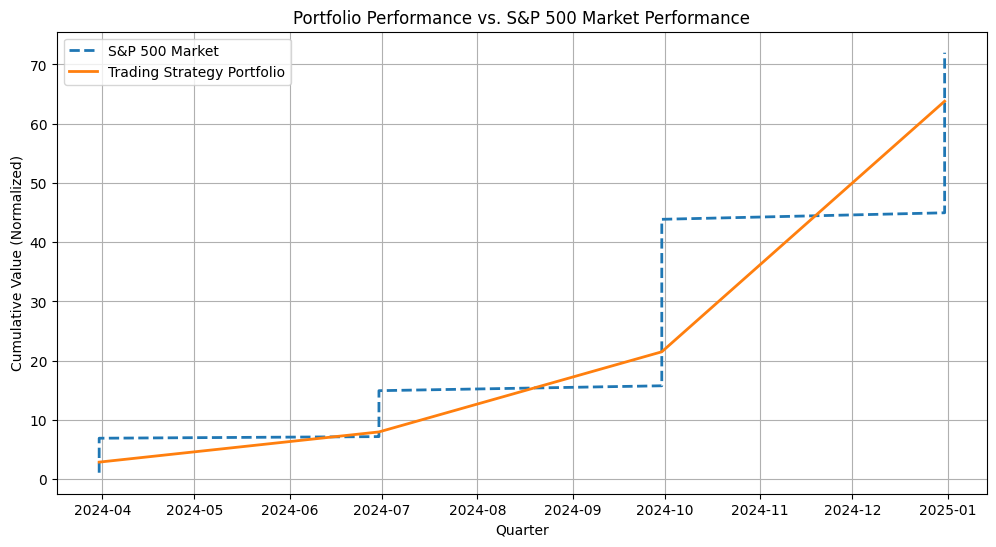

In [264]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot S&P 500 performance
plt.plot(performance_comparison['Date'], performance_comparison['Market Cumulative Value'], label="S&P 500 Market", linestyle='dashed', linewidth=2)

# Plot portfolio performance
plt.plot(performance_comparison['Date'], performance_comparison['Portfolio Value'], label="Trading Strategy Portfolio", linewidth=2)

plt.title("Portfolio Performance vs. S&P 500 Market Performance")
plt.xlabel("Quarter")
plt.ylabel("Cumulative Value (Normalized)")
plt.legend()
plt.grid()
plt.show()


In [265]:
# Compute Annualized Return
portfolio_annualized_return = np.exp(performance_comparison['Portfolio Value'].iloc[-1]) ** (1 / len(performance_comparison)) - 1
market_annualized_return = np.exp(performance_comparison['Market Cumulative Value'].iloc[-1]) ** (1 / len(performance_comparison)) - 1

# Compute Annualized Volatility
portfolio_volatility = performance_comparison['Portfolio Value'].pct_change().std() * np.sqrt(4)  # Quarterly to Annualized
market_volatility = performance_comparison['Market Cumulative Value'].pct_change().std() * np.sqrt(4)

# Compute Sharpe Ratios (Assume risk-free rate = 0)
portfolio_sharpe_ratio = portfolio_annualized_return / portfolio_volatility
market_sharpe_ratio = market_annualized_return / market_volatility

# Print Results
print(f"Portfolio Annualized Return: {portfolio_annualized_return:.2%}")
print(f"Market Annualized Return: {market_annualized_return:.2%}")
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")
print(f"Market Volatility: {market_volatility:.2%}")
print(f"Portfolio Sharpe Ratio: {portfolio_sharpe_ratio:.2f}")
print(f"Market Sharpe Ratio: {market_sharpe_ratio:.2f}")


Portfolio Annualized Return: 121.99%
Market Annualized Return: 145.89%
Portfolio Volatility: 69.68%
Market Volatility: 5.73%
Portfolio Sharpe Ratio: 1.75
Market Sharpe Ratio: 25.44


### Align historical data with political trade data

In [208]:
quarterly_aggregated = quarterly_aggregated[quarterly_aggregated['Quarter'] > '2019Q4']
quarterly_aggregated.head()

,Ticker,Quarter,Total_Transactions,Total_Buy_Amount,Total_Sell_Amount,Net_Buy_Sell,Buy_Sell_Ratio,Log_Buy_Sell_Ratio,Z_Score,Signal,Confidence
5,AAPL,2020-03-31,32,1011000.0,7113501.0,-6102501.0,0.142124,-1.951055,-0.253835,Weak Sell - Hold,0.253835
6,AAPL,2020-06-30,25,4679500.0,3129000.0,1550500.0,1.495526,0.402478,-0.042479,Weak Sell - Hold,0.042479
7,AAPL,2020-09-30,21,41501.0,315500.0,-273999.0,0.131540,-2.028441,-0.260784,Weak Sell - Hold,0.260784
8,AAPL,2020-12-31,18,170000.0,1254500.0,-1084500.0,0.135512,-1.998694,-0.258113,Weak Sell - Hold,0.258113
9,AAPL,2021-03-31,21,223000.0,352500.0,-129500.0,0.632624,-0.457879,-0.119742,Weak Sell - Hold,0.119742


In [86]:
quarterly_aggregated['Quarter'] = quarterly_aggregated['Quarter'].dt.to_timestamp(how='end').dt.strftime('%Y-%m-%d')

In [87]:
df = top_20_stocks_per_quarter.droplevel(level=2)
df.head()

NameError: name 'top_20_stocks_per_quarter' is not defined

In [ ]:
# df = df[['Adj Close', 'Log Return', 'Momentum Score', 'Sharpe Score', 'Quarterly Score']]
# quarterly_aggregated = quarterly_aggregated[['Ticker', 'Quarter', 'Total_Transactions', 'Signal', 'Confidence']]
# quarterly_aggregated = quarterly_aggregated.rename(columns={'Quarter': 'Date'})
# quarterly_aggregated = quarterly_aggregated.set_index(['Ticker', 'Date'])
# quarterly_aggregated.head()

In [ ]:
quarterly_aggregated

In [ ]:
# df = df.reset_index()
# df = df[df['Date'] >= '2020-03-31']
# df = df.set_index(['Ticker', 'Date'])
# df

In [ ]:
quarterly_aggregated.head()

In [ ]:
# df_combined = quarterly_aggregated.join(df, how='right')